# Chembl + OpenTargets Physiochemical Analysis of Tyrosine Kinases

### Using the Chembl and OpenTargets databases, find Tyrosine Kinase inhibitors, and plot their comparative physiochemical properties. 


#### Import sys module and install PyAthena
We will use these to query the Chembl and OpenTargets data files which are in S3 in parquet format.

In [1]:
    import sys
    !{sys.executable} -m pip install PyAthena

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Import python packages we need.


In [2]:
    from pyathena import connect
    import pandas as pd
    import numpy as np
    import re
    import matplotlib.pyplot as plt

#### Create Athena connection 
Specify bucket/folder for staging queries. Replace with arbitrary bucket/folder.

In [3]:
    conn = connect(s3_staging_dir='s3://coredatalake-athenaresultsbucket77a2a720-o8hyg748irr0/',
                   region_name='us-east-1')

#### Get Gene Ids for Tyrosine Kinases
Create Pandas DataFrame for distinct targets in the OpenTargets database, with valid association data, matching target type of interest.


In [4]:
    chemblTKGeneIdsDF = pd.read_sql('SELECT DISTINCT target.id FROM "opentargets_1911_dl"."association_data" \
                                     WHERE LOWER(target.gene_info.name) LIKE \'%tyrosine kinase%\'', conn)

#### Create lookup hash for TK Gene Ids

In [5]:
    tkGeneIds={}
    for gi, gv in chemblTKGeneIdsDF.iterrows():
        tkGeneIds[gv[0]]=1

#### Create Regular Expression to parse targetId from evidence rows

In [6]:
    idRegex=re.compile('id=([^,]+),')

#### Create Regular Expression to parse the Chembl Id of the interacting molecule

In [7]:
    cmRegex=re.compile('chembl_molecule=http:\/\/identifiers\.org\/chembl\.compound\/([A-Z0-9]+),')

#### Create Regular Expression to parse the action-type of the molecule in the context of the target

In [8]:
    evRegex=re.compile('action_type=([^,]+),')

#### Load OpenTargets Evidence Data
Read the OpenTargets evidence_data table into a Pandas DataFrame, where entries have a Chembl datasource.
This might take a few minutes to load, and will use ~2GB of memory.

In [9]:
    evidenceTableDF = pd.read_sql('SELECT target, unique_association_fields, evidence FROM "opentargets_1911_dl"."evidence_data" WHERE unique_association_fields.datasource=\'chembl\'', conn)

#### Create working collection objects for upcoming drug query

In [10]:
    chemblTKInhibitorIds=[]
    cti_uniq={}
    geneId_chemblId_action=[]
    gca_uniq={}

#### Get Inhibitor molecules for each TK Gene Id
Iterates through all targets corresponding to our target type of interest, and for each such target, finds the interacting compounds that are inhibitors.

In [11]:
    for ei, ev in evidenceTableDF.iterrows():
        targetString=ev['target']
        targetId_match=idRegex.search(targetString)
        targetId=targetId_match.group(1)
        if targetId in tkGeneIds:
            uaf=ev['unique_association_fields']
            uaf_match=cmRegex.search(uaf)
            chemblId=uaf_match.group(1)
            evi=ev['evidence']
            ev_match=evRegex.search(evi)
            action=ev_match.group(1)
            if action=='INHIBITOR':
                gca_str=targetId+' '+chemblId+' '+action
                if not gca_str in gca_uniq:
                    print(gca_str)
                    gca_uniq[gca_str]=1
                    t = (targetId, chemblId, action)
                    geneId_chemblId_action.append(t)
                if not chemblId in cti_uniq:
                    cti_uniq[chemblId]=1
                    chemblTKInhibitorIds.append(chemblId)

ENSG00000254087 CHEMBL1421 INHIBITOR
ENSG00000037280 CHEMBL535 INHIBITOR
ENSG00000197122 CHEMBL1421 INHIBITOR
ENSG00000097007 CHEMBL1421 INHIBITOR
ENSG00000102755 CHEMBL477772 INHIBITOR
ENSG00000102755 CHEMBL502835 INHIBITOR
ENSG00000102755 CHEMBL535 INHIBITOR
ENSG00000010671 CHEMBL1873475 INHIBITOR
ENSG00000141736 CHEMBL1743082 INHIBITOR
ENSG00000141736 CHEMBL3353410 INHIBITOR
ENSG00000037280 CHEMBL502835 INHIBITOR
ENSG00000111816 CHEMBL1421 INHIBITOR
ENSG00000141736 CHEMBL1173655 INHIBITOR
ENSG00000171094 CHEMBL601719 INHIBITOR
ENSG00000037280 CHEMBL1336 INHIBITOR
ENSG00000141736 CHEMBL1201585 INHIBITOR
ENSG00000136573 CHEMBL1421 INHIBITOR
ENSG00000157404 CHEMBL941 INHIBITOR
ENSG00000157404 CHEMBL535 INHIBITOR
ENSG00000000938 CHEMBL1421 INHIBITOR
ENSG00000097007 CHEMBL255863 INHIBITOR
ENSG00000122025 CHEMBL608533 INHIBITOR
ENSG00000157404 CHEMBL477772 INHIBITOR
ENSG00000097007 CHEMBL1946170 INHIBITOR
ENSG00000105397 CHEMBL221959 INHIBITOR
ENSG00000157404 CHEMBL1908391 INHIBITOR
ENSG0

#### Check size of inhibitor id list

In [12]:
    len(chemblTKInhibitorIds)

156

#### Compare to size of unique 'target':'molecule':'action' tuples

In [13]:
    len(geneId_chemblId_action)

330

#### Inspect the id list

In [14]:
    print(chemblTKInhibitorIds)

['CHEMBL1421', 'CHEMBL535', 'CHEMBL477772', 'CHEMBL502835', 'CHEMBL1873475', 'CHEMBL1743082', 'CHEMBL3353410', 'CHEMBL1173655', 'CHEMBL601719', 'CHEMBL1336', 'CHEMBL1201585', 'CHEMBL941', 'CHEMBL255863', 'CHEMBL608533', 'CHEMBL1946170', 'CHEMBL221959', 'CHEMBL1908391', 'CHEMBL24828', 'CHEMBL1289601', 'CHEMBL1289926', 'CHEMBL3545021', 'CHEMBL2007641', 'CHEMBL554', 'CHEMBL1738797', 'CHEMBL3188267', 'CHEMBL2105717', 'CHEMBL288441', 'CHEMBL1171837', 'CHEMBL2403108', 'CHEMBL1289494', 'CHEMBL491473', 'CHEMBL3545311', 'CHEMBL180022', 'CHEMBL3707348', 'CHEMBL2109602', 'CHEMBL572881', 'CHEMBL3545427', 'CHEMBL223360', 'CHEMBL571546', 'CHEMBL3545212', 'CHEMBL3265032', 'CHEMBL3301622', 'CHEMBL2103830', 'CHEMBL2110732', 'CHEMBL522892', 'CHEMBL3545307', 'CHEMBL3545133', 'CHEMBL2323775', 'CHEMBL377300', 'CHEMBL3545301', 'CHEMBL254760', 'CHEMBL1645462', 'CHEMBL1287853', 'CHEMBL3545396', 'CHEMBL3889654', 'CHEMBL2133806', 'CHEMBL3545158', 'CHEMBL1614725', 'CHEMBL3545154', 'CHEMBL3544956', 'CHEMBL3545177

#### Create empty DataFrame that will become result collection

In [15]:
    actDF = pd.DataFrame()

#### Main query where we collect chemical properties of each molecule.
This might take a while to run.

    WHERE pmd.chembl_id=\''+id+'\' \
            AND pmd.molregno = act.molregno \
            AND cp.molregno = act.molregno \
            AND act.standard_type = \'IC50\' \
            AND act.assay_id = asy.assay_id \
            AND asy.tid = tgd.tid \
            AND tgd.pref_name LIKE \'%kinase%\' \
            AND act.standard_value IS NOT NULL \
            AND act.relation = \'=\' \
            AND tgd.target_type = \'SINGLE PROTEIN\''

In [16]:
    for id in chemblTKInhibitorIds:
        print(id)
        query = 'SELECT DISTINCT pmd.chembl_id, \
             pmd.molregno, \
             act.activity_id, \
             act.standard_value, \
             act.standard_units, \
             act.standard_type, \
             act.pchembl_value, \
             tgd.pref_name, \
             cp.mw_freebase, \
             cp.alogp, \
             CAST(cp.hba AS DOUBLE) as hba, \
             CAST(cp.hbd AS DOUBLE) as hbd, \
             cp.psa, \
             CAST(cp.rtb AS DOUBLE) as rtb, \
             cp.ro3_pass, \
             cp.acd_most_apka, \
             cp.acd_most_bpka, \
             cp.acd_logp, \
             cp.acd_logd, \
             cp.molecular_species, \
             cp.full_mwt, \
             CAST(cp.aromatic_rings AS DOUBLE) as aromatic_rings, \
             CAST(cp.heavy_atoms AS DOUBLE) as heavy_atoms, \
             cp.qed_weighted, \
             cp.mw_monoisotopic, \
             cp.full_molformula, \
             CAST(cp.hba_lipinski AS DOUBLE) as hba_lipinski, \
             CAST(cp.hbd_lipinski AS DOUBLE) as hbd_lipinski \
    FROM "chembl_25_dl"."chembl_25_public_molecule_dictionary" pmd, \
    "chembl_25_dl"."chembl_25_public_activities" act, \
    "chembl_25_dl"."chembl_25_public_assays" asy, \
    "chembl_25_dl"."chembl_25_public_target_dictionary" tgd, \
    "chembl_25_dl"."chembl_25_public_compound_properties" cp \
    WHERE pmd.chembl_id=\''+id+'\' \
        AND pmd.molregno = act.molregno \
        AND cp.molregno = act.molregno \
        AND act.standard_type = \'IC50\' \
        AND act.assay_id = asy.assay_id \
        AND asy.tid = tgd.tid \
        AND tgd.pref_name LIKE \'%kinase%\' \
        AND act.standard_value IS NOT NULL \
        AND act.relation = \'=\' \
        AND tgd.target_type = \'SINGLE PROTEIN\''
        tmpDF = pd.read_sql(query, conn)
        status = tmpDF.describe()
        actDF = actDF.append(tmpDF, sort=True)

CHEMBL1421
CHEMBL535
CHEMBL477772
CHEMBL502835
CHEMBL1873475
CHEMBL1743082
CHEMBL3353410
CHEMBL1173655
CHEMBL601719
CHEMBL1336
CHEMBL1201585
CHEMBL941
CHEMBL255863
CHEMBL608533
CHEMBL1946170
CHEMBL221959
CHEMBL1908391
CHEMBL24828
CHEMBL1289601
CHEMBL1289926
CHEMBL3545021
CHEMBL2007641
CHEMBL554
CHEMBL1738797
CHEMBL3188267
CHEMBL2105717
CHEMBL288441
CHEMBL1171837
CHEMBL2403108
CHEMBL1289494
CHEMBL491473
CHEMBL3545311
CHEMBL180022
CHEMBL3707348
CHEMBL2109602
CHEMBL572881
CHEMBL3545427
CHEMBL223360
CHEMBL571546
CHEMBL3545212
CHEMBL3265032
CHEMBL3301622
CHEMBL2103830
CHEMBL2110732
CHEMBL522892
CHEMBL3545307
CHEMBL3545133
CHEMBL2323775
CHEMBL377300
CHEMBL3545301
CHEMBL254760
CHEMBL1645462
CHEMBL1287853
CHEMBL3545396
CHEMBL3889654
CHEMBL2133806
CHEMBL3545158
CHEMBL1614725
CHEMBL3545154
CHEMBL3544956
CHEMBL3545177
CHEMBL603469
CHEMBL101253
CHEMBL2103842
CHEMBL276711
CHEMBL587723
CHEMBL3545428
CHEMBL217092
CHEMBL52885
CHEMBL2103882
CHEMBL2035187
CHEMBL3544931
CHEMBL3137331
CHEMBL124660
CHEMBL3

#### Inspect results

In [17]:
    actDF

,acd_logd,acd_logp,acd_most_apka,acd_most_bpka,activity_id,alogp,aromatic_rings,chembl_id,full_molformula,full_mwt,...,mw_monoisotopic,pchembl_value,pref_name,psa,qed_weighted,ro3_pass,rtb,standard_type,standard_units,standard_value
0,-0.27,0.14,10.94,7.29,3446265,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,6.94,LIM domain kinase 1,106.51,0.47,N,7.0,IC50,nM,114.0
1,-0.27,0.14,10.94,7.29,3446256,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,8.10,Tyrosine-protein kinase BLK,106.51,0.47,N,7.0,IC50,nM,8.0
2,-0.27,0.14,10.94,7.29,3444673,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,4.52,PI3-kinase p110-delta subunit,106.51,0.47,N,7.0,IC50,nM,30000.0
3,-0.27,0.14,10.94,7.29,1778616,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,9.70,Tyrosine-protein kinase FYN,106.51,0.47,N,7.0,IC50,nM,0.2
4,-0.27,0.14,10.94,7.29,1778614,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,6.15,Receptor protein-tyrosine kinase erbB-2,106.51,0.47,N,7.0,IC50,nM,710.0
5,-0.27,0.14,10.94,7.29,12623384,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,9.60,Tyrosine-protein kinase ABL,106.51,0.47,N,7.0,IC50,nM,0.25
6,-0.27,0.14,10.94,7.29,12623336,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,9.66,Tyrosine-protein kinase ABL,106.51,0.47,N,7.0,IC50,nM,0.22
7,-0.27,0.14,10.94,7.29,3396634,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,9.40,Tyrosine-protein kinase SRC,106.51,0.47,N,7.0,IC50,nM,0.4
8,-0.27,0.14,10.94,7.29,2626854,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,9.40,Tyrosine-protein kinase SRC,106.51,0.47,N,7.0,IC50,nM,0.4
9,-0.27,0.14,10.94,7.29,6390453,3.31,3.0,CHEMBL1421,C22H26ClN7O2S,488.02,...,487.1557,8.52,Tyrosine-protein kinase LCK,106.51,0.47,N,7.0,IC50,nM,3.0


## Analysis

### Specificity
Do inihibitors that are not specific have a common pattern?

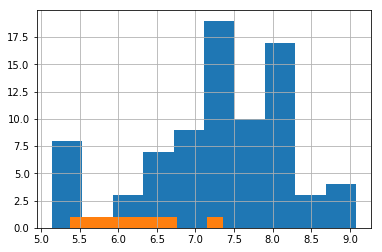

In [18]:
#actDF[actDF.chembl_id=='CHEMBL1336'].plot(kind='hist', x='pchembl_value', y='pchembl_value', color='red')
actDF[actDF.chembl_id=='CHEMBL1336']['pchembl_value'].hist()
actDF[actDF.chembl_id=='CHEMBL564829']['pchembl_value'].hist()

## Plot Results for Physiochemical Properies
Below we plot a variety of chemical properties (y-axis) against the negative log of the IC50 value of each molecule (x-axis), which is a linearized way
of visualizing the relative potency of the molecule against its corresponding target in Chembl.

## Molecular weight


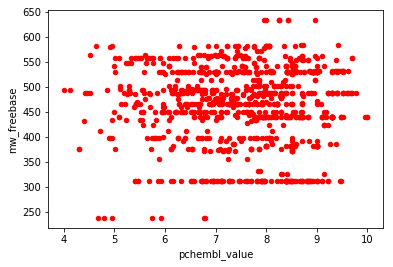

In [19]:
    actDF.plot(kind='scatter',x='pchembl_value',y='mw_freebase',color='red')
    plt.show()

## Calculated ALogP
Proxy for lipophilicity, which in turn is a proxy for specificify (the lower the better)

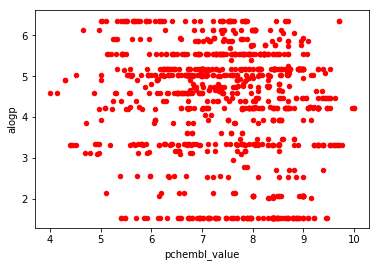

In [20]:
    actDF.plot(kind='scatter',x='pchembl_value',y='alogp',color='red')
    plt.show()

## Polar surface area

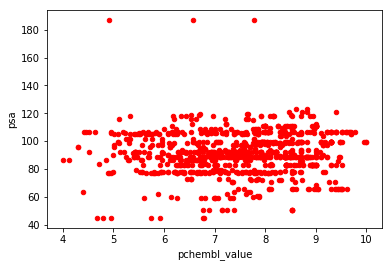

In [21]:
    actDF.plot(kind='scatter',x='pchembl_value',y='psa',color='red')
    plt.show()

## ACDLogP
A variation of ALogP, measuring lipophilicity

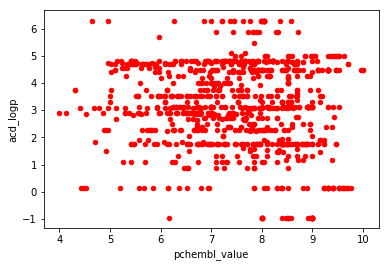

In [22]:
    actDF.plot(kind='scatter',x='pchembl_value',y='acd_logp',color='red')
    plt.show()

## Full molecular weight
Includes salts

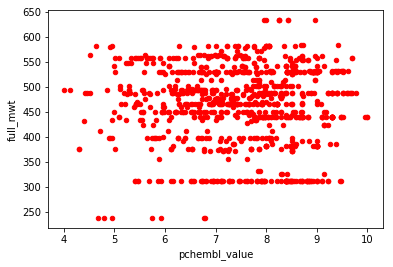

In [23]:
    actDF.plot(kind='scatter',x='pchembl_value',y='full_mwt',color='red')
    plt.show()

## QED
Weighted quantitative measurement of drug-likeness (as defined by Bickerton et al, Nature Chem, 2012)

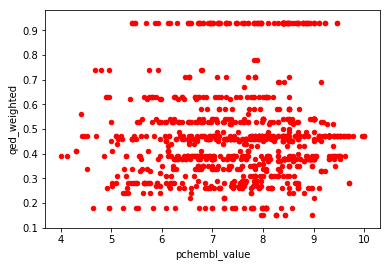

In [24]:
    actDF.plot(kind='scatter',x='pchembl_value',y='qed_weighted',color='red')
    plt.show()

## Monoisotopic molecular weight

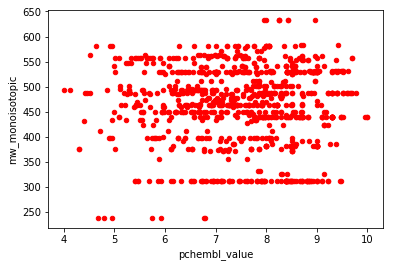

In [25]:
    actDF.plot(kind='scatter',x='pchembl_value',y='mw_monoisotopic',color='red')
    plt.show()

## Number of aromatic rings
Fewer is usually better for drug development

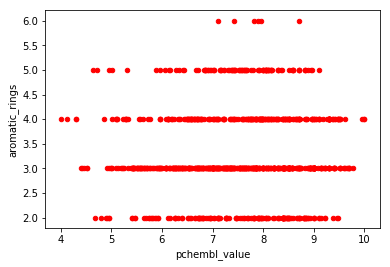

In [26]:
    actDF.plot(kind='scatter',x='pchembl_value',y='aromatic_rings',color='red')
    plt.show()

## Number of heavy (i.e., non-hydrogen) atoms
More is usually better for drug development

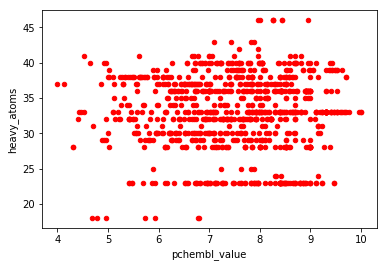

In [27]:
    actDF.plot(kind='scatter',x='pchembl_value',y='heavy_atoms',color='red')
    plt.show()

## HBA
Number of hydrogen bond acceptors

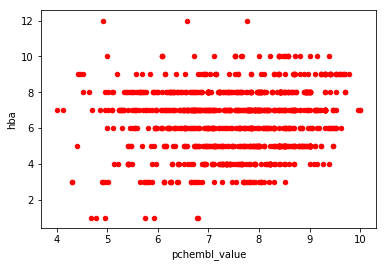

In [28]:
    actDF.plot(kind='scatter',x='pchembl_value',y='hba',color='red')
    plt.show()

## HBD
Number of hydrogen bond donors

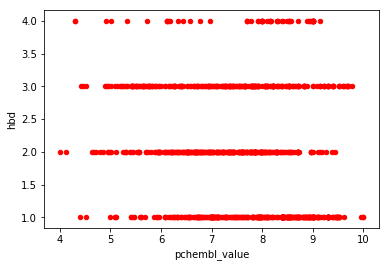

In [29]:
    actDF.plot(kind='scatter',x='pchembl_value',y='hbd',color='red')
    plt.show()

## RTB
Number of rotatable bonds, more is better for oral bioavailability

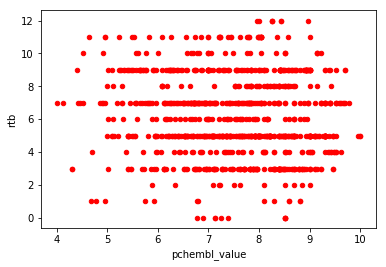

In [30]:
    actDF.plot(kind='scatter',x='pchembl_value',y='rtb',color='red')
    plt.show()

## HBA component of "Lipinski's rule of 5"

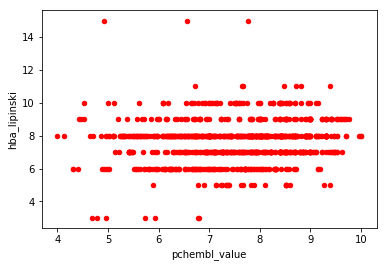

In [31]:
    actDF.plot(kind='scatter',x='pchembl_value',y='hba_lipinski',color='red')
    plt.show()

## HBD component of "Lipinski's rule of 5"

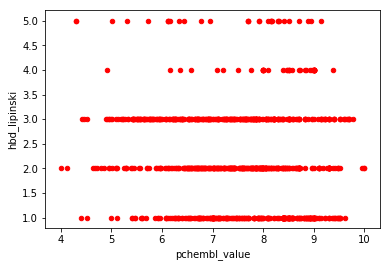

In [32]:
    actDF.plot(kind='scatter',x='pchembl_value',y='hbd_lipinski',color='red')
    plt.show()